# 1. Libraries

In [4]:
#Importing packages

import os
import numpy as np
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import seaborn as sns
import itertools
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalMaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dropout,
    Input,
    BatchNormalization,
    Dense
)
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

E0000 00:00:1758911948.519815      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758911948.601435      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# === 1. Dataset Klasör Yapısını Keşfet ===
base_path = "/kaggle/input/brain-tumor-mri-dataset"

print("📂 Dataset klasör yapısı:")
for dirname, subdirs, files in os.walk(base_path):
    print(f"- {dirname} | Klasörler: {subdirs[:5]} | Dosyalar: {files[:5]}")

# Train/Test klasör adlarını otomatik bul
subdirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
subdirs_lower = [d.lower() for d in subdirs]

if "train" in subdirs_lower:
    train_dir = os.path.join(base_path, subdirs[subdirs_lower.index("train")])
elif "training" in subdirs_lower:
    train_dir = os.path.join(base_path, subdirs[subdirs_lower.index("training")])
else:
    raise FileNotFoundError("Train klasörü bulunamadı! Klasör adını kontrol et.")

if "test" in subdirs_lower:
    test_dir = os.path.join(base_path, subdirs[subdirs_lower.index("test")])
elif "testing" in subdirs_lower:
    test_dir = os.path.join(base_path, subdirs[subdirs_lower.index("testing")])
else:
    raise FileNotFoundError("Test klasörü bulunamadı! Klasör adını kontrol et.")

print(f"✅ Train klasörü: {train_dir}")
print(f"✅ Test klasörü:  {test_dir}")

📂 Dataset klasör yapısı:
- /kaggle/input/brain-tumor-mri-dataset | Klasörler: ['Training', 'Testing'] | Dosyalar: []
- /kaggle/input/brain-tumor-mri-dataset/Training | Klasörler: ['pituitary', 'notumor', 'meningioma', 'glioma'] | Dosyalar: []
- /kaggle/input/brain-tumor-mri-dataset/Training/pituitary | Klasörler: [] | Dosyalar: ['Tr-pi_0532.jpg', 'Tr-pi_0282.jpg', 'Tr-pi_1401.jpg', 'Tr-pi_0914.jpg', 'Tr-pi_0691.jpg']
- /kaggle/input/brain-tumor-mri-dataset/Training/notumor | Klasörler: [] | Dosyalar: ['Tr-no_0482.jpg', 'Tr-no_0641.jpg', 'Tr-no_0592.jpg', 'Tr-no_0711.jpg', 'Tr-no_0746.jpg']
- /kaggle/input/brain-tumor-mri-dataset/Training/meningioma | Klasörler: [] | Dosyalar: ['Tr-me_0529.jpg', 'Tr-me_1256.jpg', 'Tr-me_0852.jpg', 'Tr-me_0494.jpg', 'Tr-me_1293.jpg']
- /kaggle/input/brain-tumor-mri-dataset/Training/glioma | Klasörler: [] | Dosyalar: ['Tr-gl_0954.jpg', 'Tr-gl_0959.jpg', 'Tr-gl_1033.jpg', 'Tr-gl_1096.jpg', 'Tr-gl_1290.jpg']
- /kaggle/input/brain-tumor-mri-dataset/Testing |

# 2. Normalization ve Görüntü Dönüşümleri

In [6]:
# === 2. Görüntü Dönüşümleri === Normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize([0.5], [0.5])
])

# 3. Dataset Dağılımı

In [7]:
# 3. Veri Hakkında Bilgi Al

train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"

classes = sorted([d for d in os.listdir(train_dir)
                  if os.path.isdir(os.path.join(train_dir, d))])


print(f"Sınıflar (train): {classes}")
for c in classes:
    n = len([f for f in os.listdir(os.path.join(train_dir, c))
             if os.path.isfile(os.path.join(train_dir, c, f))])
    print(f"{c} klasöründe {n} görüntü var.")

Sınıflar (train): ['glioma', 'meningioma', 'notumor', 'pituitary']
glioma klasöründe 1321 görüntü var.
meningioma klasöründe 1339 görüntü var.
notumor klasöründe 1595 görüntü var.
pituitary klasöründe 1457 görüntü var.


In [8]:
# === 3. Dataset ve DataLoader ===

train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=4, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Sınıflar: {train_dataset.classes}")

Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 4. Örnek Dataset Görselleri

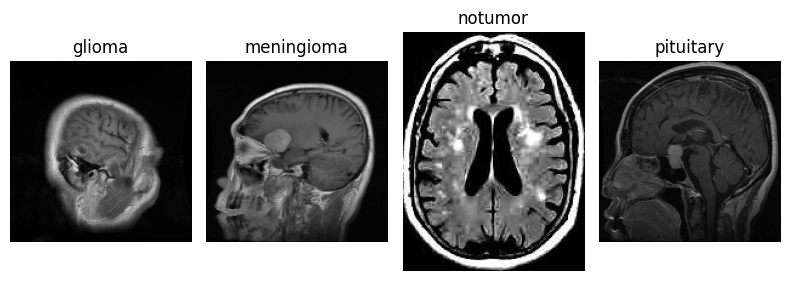

In [ ]:
# 4. Örnek Görselleri Görüntüle
import glob, random
import matplotlib.pyplot as plt
import PIL.Image as Image

samples = []
for c in classes[:4]:
    cdir = os.path.join(train_dir, c)
    files = glob.glob(os.path.join(cdir, "*.*"))
    if files:
        samples.append((c, random.choice(files)))

plt.figure(figsize=(8, 8))
for i, (label, fpath) in enumerate(samples, 1):
    img = Image.open(fpath).convert("RGB")
    plt.subplot(1,4,i)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

# 5. Ön İşleme & Augmentation

In [10]:
# 5. ImageDataGenerator ile Ön İşleme & Augmentation
IMG_SIZE = (128, 128)  # boyutu sabitle
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize
    rotation_range=15,           # ±15 derece döndür
    width_shift_range=0.1,       # yatay kaydır
    height_shift_range=0.1,      # dikey kaydır
    zoom_range=0.2,              # yakınlaştır/uzaklaştır
    horizontal_flip=True,        # yatay çevir
    validation_split=0.2         # %20 validation seti
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

print(f"\nSınıf indeksleri: {train_generator.class_indices}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.

Sınıf indeksleri: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 6. Augmentation Sonrası Örnek Görüntüler 

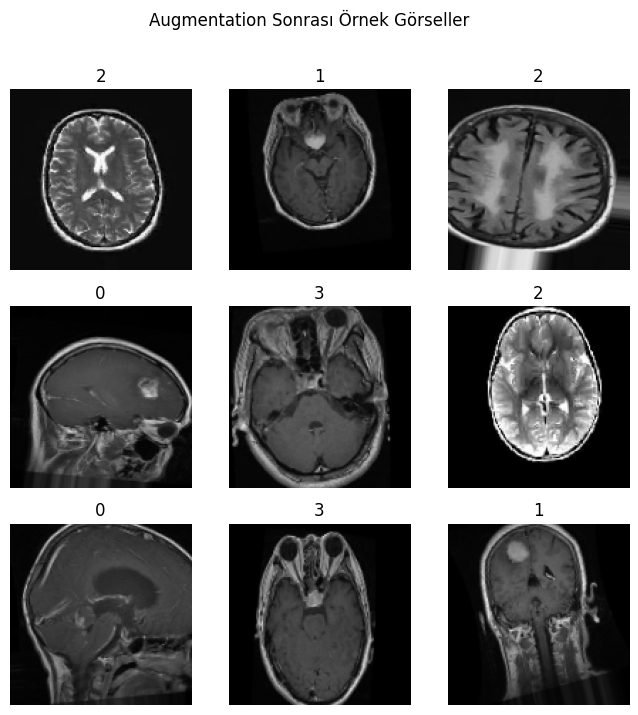

In [ ]:
# 6. Örnek Augmentation Sonrası Görselleri Göster
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis("off")
plt.suptitle("Augmentation Sonrası Örnek Görseller")
plt.show()

# 7. CNN Model Mimarisi

In [12]:
# === 7. CNN Modeli + Device ===
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False)
        self.pool  = nn.MaxPool2d(2, 2)
        self.bn1   = nn.BatchNorm2d(16)
        self.bn2   = nn.BatchNorm2d(32)
        self.gap   = nn.AdaptiveAvgPool2d(1)
        self.fc1   = nn.Linear(32, 128)
        self.fc2   = nn.Linear(128, num_classes)
        self.drop  = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.gap(x)              # (B,32,1,1)
        x = torch.flatten(x, 1)      # (B,32)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

# === Device Secimi ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanilan device:", device)
model = BrainTumorCNN(num_classes=len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print(model)

Kullanilan device: cuda
BrainTumorCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
)


In [13]:
# === Egitirken tahmini egitim suresini ogrenmek icin ===
!pip -q install tqdm
from tqdm.auto import tqdm

# 8. Training

In [ ]:
# === 8. Egitim ===
from copy import deepcopy

patience = 8
min_delta = 1e-4
best_val = float("inf")
wait = 0
best_state = None

epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # tqdm:  "Epoch 1/5  4/777 ... ETA ...  loss: ...  acc: ..."
    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader),
                desc=f"Epoch {epoch+1}/{epochs}")

    for step, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct     += (predicted == labels).sum().item()
        total       += labels.size(0)

        # Anlık (kümülatif) ortalama
        batch_loss = running_loss / total
        batch_acc  = correct / total

        # tqdm satırındaki postfix (ETA’yı tqdm otomatik gösterir)
        pbar.set_postfix(loss=f"{batch_loss:.4f}", accuracy=f"{batch_acc:.4f}")

    # Epoch sonu train metrikleri
    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ===== Validation =====
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss    += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total   += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(val_correct / val_total)

    # Epoch özeti (tqdm dışında da net görmek istersen)
    print(f"Epoch {epoch+1}/{epochs} "
          f"| Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
          f"| Val Loss: {val_losses[-1]:.4f} Acc: {val_accs[-1]:.4f}")

    if best_val - val_loss > min_delta:
        best_val = val_loss
        best_state = deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_state) # en iyi agirliklara don
            break

Epoch 1/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 0.6315 Acc: 0.7616 | Val Loss: 0.7131 Acc: 0.7101


Epoch 2/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 0.6304 Acc: 0.7549 | Val Loss: 0.7049 Acc: 0.7239


Epoch 3/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 0.6259 Acc: 0.7631 | Val Loss: 0.6998 Acc: 0.7117


Epoch 4/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 0.6294 Acc: 0.7619 | Val Loss: 0.6982 Acc: 0.7063


Epoch 5/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 0.6197 Acc: 0.7623 | Val Loss: 0.7335 Acc: 0.7193


Epoch 6/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 0.6137 Acc: 0.7712 | Val Loss: 0.6856 Acc: 0.7155


Epoch 7/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.6137 Acc: 0.7672 | Val Loss: 0.6732 Acc: 0.7239


Epoch 8/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.6152 Acc: 0.7691 | Val Loss: 0.7159 Acc: 0.7285


Epoch 9/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.6080 Acc: 0.7708 | Val Loss: 0.6936 Acc: 0.7239


Epoch 10/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.6031 Acc: 0.7722 | Val Loss: 0.7658 Acc: 0.7002


Epoch 11/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.6083 Acc: 0.7710 | Val Loss: 0.6718 Acc: 0.7323


Epoch 12/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.6012 Acc: 0.7717 | Val Loss: 0.7139 Acc: 0.7147


Epoch 13/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.5985 Acc: 0.7679 | Val Loss: 0.7325 Acc: 0.7193


Epoch 14/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.5946 Acc: 0.7745 | Val Loss: 0.6568 Acc: 0.7307


Epoch 15/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.5927 Acc: 0.7785 | Val Loss: 0.7068 Acc: 0.7262


Epoch 16/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.5984 Acc: 0.7742 | Val Loss: 0.6601 Acc: 0.7162


Epoch 17/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.5867 Acc: 0.7806 | Val Loss: 0.6933 Acc: 0.7269


Epoch 18/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.5846 Acc: 0.7799 | Val Loss: 0.6454 Acc: 0.7323


Epoch 19/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.5782 Acc: 0.7799 | Val Loss: 0.6700 Acc: 0.7094


Epoch 20/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.5822 Acc: 0.7831 | Val Loss: 0.6765 Acc: 0.7193


Epoch 21/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.5748 Acc: 0.7820 | Val Loss: 0.6445 Acc: 0.7285


Epoch 22/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 22/100 | Train Loss: 0.5840 Acc: 0.7782 | Val Loss: 0.7387 Acc: 0.6934


Epoch 23/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 23/100 | Train Loss: 0.5830 Acc: 0.7735 | Val Loss: 0.6366 Acc: 0.7307


Epoch 24/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 24/100 | Train Loss: 0.5748 Acc: 0.7784 | Val Loss: 0.6380 Acc: 0.7384


Epoch 25/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 25/100 | Train Loss: 0.5750 Acc: 0.7834 | Val Loss: 0.6659 Acc: 0.7201


Epoch 26/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 26/100 | Train Loss: 0.5726 Acc: 0.7857 | Val Loss: 0.7387 Acc: 0.7063


Epoch 27/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 27/100 | Train Loss: 0.5689 Acc: 0.7782 | Val Loss: 0.7152 Acc: 0.7277


Epoch 28/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 28/100 | Train Loss: 0.5739 Acc: 0.7878 | Val Loss: 0.6319 Acc: 0.7468


Epoch 29/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 29/100 | Train Loss: 0.5632 Acc: 0.7859 | Val Loss: 0.6882 Acc: 0.7185


Epoch 30/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 30/100 | Train Loss: 0.5602 Acc: 0.7903 | Val Loss: 0.6796 Acc: 0.7376


Epoch 31/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 31/100 | Train Loss: 0.5537 Acc: 0.7932 | Val Loss: 0.6183 Acc: 0.7323


Epoch 32/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 32/100 | Train Loss: 0.5607 Acc: 0.7876 | Val Loss: 0.6397 Acc: 0.7277


Epoch 33/100:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 33/100 | Train Loss: 0.5490 Acc: 0.7938 | Val Loss: 0.7104 Acc: 0.7071


Epoch 34/100:   0%|          | 0/90 [00:00<?, ?it/s]

# 9. Confusion Matrix

In [19]:
# === Confusion Matrix ===
def evaluate_confusion_matrix(model, dataloader, class_names, device="cuda"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Daha detaylı rapor
    print(classification_report(y_true, y_pred, target_names=class_names))

In [20]:
evaluate_confusion_matrix(model, val_loader, class_names=["glioma","meningioma","pituitary","no_tumor"], device=device)


NameError: name 'val_loader' is not defined

In [17]:
# === 6. Test Doğruluğu ===
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🎯 Test Doğruluk: {100 * correct / total:.2f}%")

🎯 Test Doğruluk: 72.01%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

plt.show()